In [1]:
import sys
import glob
import os
import ee
import math
import random
import pandas as pd
import numpy as np
import geopandas as gp
import seaborn as sns
import rsfuncs as rs

import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy import stats
from scipy.signal import savgol_filter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, StratifiedKFold

from pandas.tseries.offsets import MonthEnd, SemiMonthEnd
from datetime import datetime, timedelta
from datetime import datetime as dt

from keras import regularizers, optimizers
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [10,6]

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
# Numeric NLCD vals to class labels
nlcd= {0: "Open water",
1 : "Perennial ice/snow",
2 : "Developed",
3 : "Developed, low intensity",
4 : "Developed, medium intensity",
5 : "Developed high intensity",
6 : "Barren land (rock/sand/clay)",
7 : "Deciduous forest", 
8 : "Evergreen forest",
9 : "Mixed forest",
10 : "Dwarf scrub",
11 : "Shrub/scrub",
12 : "Grassland/herbaceous",
13 : "Sedge/herbaceous",
14 : "Lichens",
15 : "Moss",
16 : "Pasture/hay",
17 : "Cultivated crops",
18 : "Woody wetlands",
19 : "Emergent herbaceous wetlands"}


In [3]:
# Read data

In [4]:
data_dir = "../data"

states_file = gp.read_file("../shape/states.shp")
states = states_file[~states_file['STATE_ABBR'].isin(["AK", "HI", "PR", "VI"])]

site_file = gp.read_file("../shape/scan_sites.shp")
sites = site_file[~site_file['state'].isin(["AK", "HI", "PR", "VI"])]


In [5]:
# Read and format the RS data 

df = pd.read_csv("../data/all_dat_f.csv")
df.rename(columns={ df.columns[0]: "site" , df.columns[1]:"date"}, inplace = True)
df.replace([np.inf, -np.inf], np.nan, inplace = True)
df = df.set_index(pd.to_datetime(df.date))
df['date'] = pd.to_datetime(df.date)

# Remove outliers
# df = df[~(np.abs(df.psi_rz-df.psi_rz.mean()) > (df.psi_rz.std()))]

In [6]:
# Filter the data

# Drop days with 2day precip less than 1 mm
df = df[df.precip<1]

# Remove Urban Areas
df = df[df.lc_type != 2]
df = df[df.lc_type != 3]
df = df[df.lc_type != 4]
df = df[df.lc_type != 5]

# Remove sites with <10 datapoints
for i in df.site.unique():
    if len(df[df.site == i]) < 10:
        df = df[df.site != i]

# Calculate spectral indices
# df['ndvi'] = (df.B5 - df.B4) / (df.B5 + df.B4)
# df["ndmi"] = (df.B5 - df.B6) / (df.B5 + df.B6)
# df["evi"] = 2.5*(df.B5 - df.B4) / (df.B5 + 6*df.B4- 7.5*df.B2 + 1)

df['ndvi'] = (df.B5_filt - df.B4_filt) / (df.B5_filt + df.B4_filt)
df["ndmi"] = (df.B5_filt - df.B6_filt) / (df.B5_filt + df.B6_filt)
df["evi"] = 2.5*(df.B5_filt - df.B4_filt) / (df.B5_filt + 6*df.B4_filt - 7.5*df.B2_filt + 1)

# For the backscatter columns (df.vv, df.hv), delete any zeros, nans, deal with weird formatting, and calc the mean of the 3 pixels
vv_eff = []

for i in df.vv:
    line = i.replace("[","")
    line = line.replace("]","")
    line = ' '.join(line.split())
    data = [float(i) for i in line.split(' ')]
    data = [i for i in data if i !=0.]
    vv_eff.append(np.nanmean(data))
    

hv_eff = []

for i in df.hv:
    if type(i) is float:
        hv_eff.append(np.nan)
    else:
        line = i.replace("[","")
        line = line.replace("]","")
        line = ' '.join(line.split())
        data = [float(i) for i in line.split(' ')]
        data = [i for i in data if i !=0.]
        hv_eff.append(np.nanmean(data))


df['vv'] = vv_eff
df['hv'] = hv_eff

In [7]:
# Select the filtered sites from the shapefile

In [8]:
validsites = [x for x in sites.id if int(x) in df.site.unique()]
sites = sites[sites.id.isin(validsites)]

In [9]:
# Join the scan data and rs data

# Scan join cols
join_cols = ["id","elev", "clay_fract", "silt_fract", "sand_fract", "a", "b"]
jdf = sites[join_cols]

In [10]:
df = pd.merge(df, jdf.astype(float), right_on= "id", left_on= "site", how = "inner")

### Compute the depth weighted root zone soil moisture for each site

Based on Jackson et al., 1996:

https://www.agro.uba.ar/users/sala/pdfs/063-oecol96c.pdf

Jackson, R. B., Canadell, J., Ehleringer, J. R., Mooney, H. A., Sala, O. E., & Schulze, E. D. (1996). A global analysis of root distributions for terrestrial biomes. Oecologia, 108(3), 389-411.

#### Equation 1:  $ Y =  1- \beta ^d $

Y is root density, d is depth, $\beta$ is empirical parameter

#### From table 1
grasses: $\beta$ = 0.952
trees: $\beta$ = 0.970
shrubs: $\beta$ = 0.978
...

In [11]:
def calc_y(depth,beta):
    y = 1-beta**depth
    return y

def calc_weighted_avg(ys):
    return [x/sum(ys) for x in ys]

In [12]:
# These beta values correspond to landcover types in NLCD 
beta_dict = { 
        12: 0.952,
        11: 0.978,
        17: 0.961,
        7: 0.970,
        16: 0.952,
        8: 0.970,
        6: 0.914, 
        }

In [13]:
# Now loop through each site id, read the SCAN soil moisture from data dir, compute the depth averaged SM

In [14]:
# Helper to read a SCAN site text file and return the data as a dataframe 

def read_sm_file(filename):
    with open(filename) as f:
        contents = f.readlines()

    data = []
    for line in contents:
        if line[0:1] == "#":
            continue
        else:
            data.append(line)

    headers = [x.replace("Soil Moisture Percent","smp").replace(" ","_") for x in data[0].split(",")]
    cols = [x.strip("\n").split(",") for x in data[1:]]

    df = pd.DataFrame(cols, columns = headers)
    
    return df


In [15]:
# Heres the big loop

In [15]:
# Setup the results datastructures 
spatial_stats = {}
temporal_stats = {}

lcstats = { 
        12: [],
        11: [],
        17: [],
        7: [],
        16: [],
        8: [],
        6: [], 
        }

lcstats_daily = { 
        12: [],
        11: [],
        17: [],
        7: [],
        16: [],
        8: [],
        6: [], 
        }

out_dfs = []

for idx, row in sites.iterrows():
        
    print("Processings site no {}".format(row.id))
    
    # Get the corresponding SCAN data file from data folder
    site_id = row.id
    sm_file = [os.path.join(data_dir,x) for x in os.listdir(data_dir) if site_id in x][0]
    sm_dat = read_sm_file(sm_file)
    sm_dat['Date'] =  pd.to_datetime(sm_dat['Date'], format='%Y%m%d %H:%M')
    sm_dat.set_index('Date', inplace=True)
    
    if sm_dat.empty:
        print("no valid data")
        continue 
    
    # Rename the columns to the depths in cm (approx)
    sm_dat.rename(columns= { 
                        sm_dat.columns[0]: "5",
                        sm_dat.columns[1]: "10",
                        sm_dat.columns[2]: "20",
                        sm_dat.columns[3]: "50",
                        sm_dat.columns[4]: "100"
                        }, inplace = True)
    
    # Eliminate whitespace and drop rows with nans 
    sm_dat = sm_dat.replace(r'^\s*$', np.nan, regex=True)
    sm_dat = sm_dat.dropna()
    
    if sm_dat.empty:
        print("no valid data")
        continue 
        
    # Get the RS data for that site 
    rsdf = df[df.id == int(row.id)]
    lct = rsdf.lc_type.unique()[0]
    beta = beta_dict[lct]
    
    # Calculate the weighted sum for each row 
    was = []
    wsvar = []
    for idx, x in sm_dat.iterrows():
        depths = x.index.values
        depths = [float(x) for x in depths]
        ys = [calc_y(x,beta) for x in depths]
        wa = np.array(calc_weighted_avg(ys))
        smvals = [float(j) for j in x.values]
        weighted_sum = np.array(smvals*wa).sum()
        wsvar.append(np.var(np.array(smvals)))
        was.append(weighted_sum)
    
    # append the weighted sums to the dataframe 
    sm_dat['wa'] = was
    
    # Compute the sm anomaly across all times 
    sm_dat['wa_anom'] = sm_dat['wa'] - np.mean(sm_dat['wa'])
    
    # Rename numeric cols 
    sm_dat = sm_dat.rename(columns={"5": "d5", "10": "d10", "20":"d20", "50": "d50", "100":"d100"})
    
    # For each landcover type, append all soil moisture data 
    lcstats[lct].append([sm_dat])
    
    # For every landcover type, get data between 3 am - 7 am and append
    sm_dat_daily = sm_dat.between_time('4:00', '7:00')
    lcstats_daily[lct].append([sm_dat_daily])

    # For all the dates with RS data, extract the depth averaged sm and join it to the master df
    sdf = df[df.site == int(row.id)]
    sdf.set_index(pd.to_datetime(sdf.date), inplace = True)
    dates = sdf.index
    
    rzsm = []
    
    # for each date with RS data, select matching 3-7 am from the SCAN data 
    for i in dates:
        starttime = i.replace(second=0, microsecond=0, minute=0, hour=3)
        endtime = starttime+timedelta(hours= 4)
        ddf = pd.DataFrame(sm_dat[starttime:endtime])
        rzsm.append(ddf)
    
    # daily (i.e. 3am - 7 am) means
    resampled = pd.concat(rzsm).resample("D").mean()
    sdf = sdf.resample("D").mean()
        
    # merge the resampled df to the site df
    final = pd.merge(sdf, resampled, left_index = True, right_index = True, how = "inner").dropna()
        
    out_dfs.append(final)
    print("====" * 10 )

Processings site no 2214
no valid data
Processings site no 2215
Processings site no 2189
Processings site no 2190
Processings site no 2187
Processings site no 2183
Processings site no 2191
Processings site no 2192
Processings site no 2185
Processings site no 2184
Processings site no 2218
Processings site no 2149
Processings site no 2217
Processings site no 2186
Processings site no 2219
Processings site no 2197
Processings site no 2148
no valid data
Processings site no 674
no valid data
Processings site no 2117
Processings site no 2019
Processings site no 2121
Processings site no 581
Processings site no 2119
Processings site no 808
Processings site no 2118
Processings site no 2111
Processings site no 2069
Processings site no 2015
Processings site no 2172
Processings site no 2107
Processings site no 2168
Processings site no 2169
Processings site no 2171
Processings site no 2108
Processings site no 2216
no valid data
Processings site no 2145
Processings site no 2141
Processings site no 21

In [35]:
for k,v in lcstats.items():
    vdfs = []
    for i in v:
        vdfs.append(i[0])
    print("{} n sites = {} n measurements = {} ".format(nlcd[k], len(v), len(pd.concat(vdfs))))
    mean_sm = np.mean(pd.concat(vdfs).wa)
    var_sm = np.var(pd.concat(vdfs).wa)
    
    print(mean_sm, var_sm)

Grassland/herbaceous n sites = 9 n measurements = 246089 
15.504890111415275 62.502774112754174
Shrub/scrub n sites = 32 n measurements = 919297 
11.708617887963136 60.78688196390356
Cultivated crops n sites = 20 n measurements = 631832 
19.809929862448318 89.30743311783479
Deciduous forest n sites = 1 n measurements = 25762 
28.541963874955343 10.136923483649944
Pasture/hay n sites = 3 n measurements = 105333 
22.850981212981928 9.14863688665191
Evergreen forest n sites = 4 n measurements = 128013 
14.216283025532402 54.05445884455188
Barren land (rock/sand/clay) n sites = 2 n measurements = 46831 
9.86045704548086 8.45327514151142


In [36]:
for k,v in lcstats_daily.items():
    vdfs = []
    for i in v:
        vdfs.append(i[0])
    print("{} n sites = {} n measurements = {} ".format(nlcd[k], len(v), len(pd.concat(vdfs))))
    mean_sm = np.mean(pd.concat(vdfs).wa)
    var_sm = np.var(pd.concat(vdfs).wa)
    
    print(mean_sm, var_sm)

Grassland/herbaceous n sites = 9 n measurements = 40792 
15.493505145324955 62.41539592563928
Shrub/scrub n sites = 32 n measurements = 153290 
11.659321046696661 60.41761228080293
Cultivated crops n sites = 20 n measurements = 104784 
19.81139050024486 89.50641499951503
Deciduous forest n sites = 1 n measurements = 4287 
28.547099354131674 10.073539016017484
Pasture/hay n sites = 3 n measurements = 17554 
22.808951856622787 9.100898384529795
Evergreen forest n sites = 4 n measurements = 21324 
14.187031694107011 54.26649871952097
Barren land (rock/sand/clay) n sites = 2 n measurements = 7804 
9.708606797928574 8.297908745329357


# For overpasses times: 

make violin plots to inspect the mean and variance of raw data weighted averages and weighted average anomaly 

In [37]:
analysis_df = pd.concat(out_dfs)
# analysis_df.columns = lclabels

<a list of 7 Text xticklabel objects>


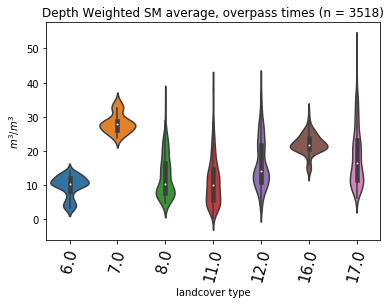

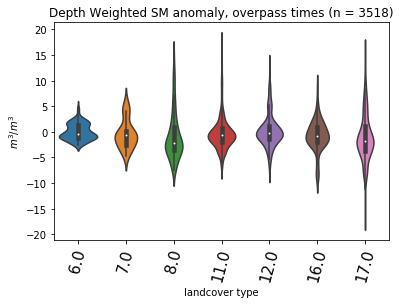

In [38]:
# Plot depth weighted sum of SM violin plot for each lc type only during overpass dates 
p=sns.violinplot(x="lc_type", y="wa", data=analysis_df)
plt.title("Depth Weighted SM average, overpass times (n = {})".format(str(len(analysis_df))))
plt.xlabel("landcover type")
print(plt.gca().get_xticklabels())
# p.set_xticklabels([nlcd[k] for k in plt.gca().get_xticklabels()])
plt.xticks(rotation=75, size = 15)
plt.ylabel("$m^3/ m^3$")
plt.show()

# Plot anomalies of SM violin plot for each lc type only during overpass dates 
p2 = sns.violinplot(x="lc_type", y="wa_anom", data=analysis_df)
# plt.title("Depth Weighted SM anomaly ($X_i' = X_i - \bar{x} $)" + ", overpass times (n = {})".format(str(len(analysis_df))))
plt.title("Depth Weighted SM anomaly, overpass times (n = {})".format(str(len(analysis_df))))

plt.xlabel("landcover type")
plt.ylabel("$m^3/ m^3$")
plt.xticks(rotation=75, size = 15)
# p2.set_xticklabels(lclabels)

plt.show()

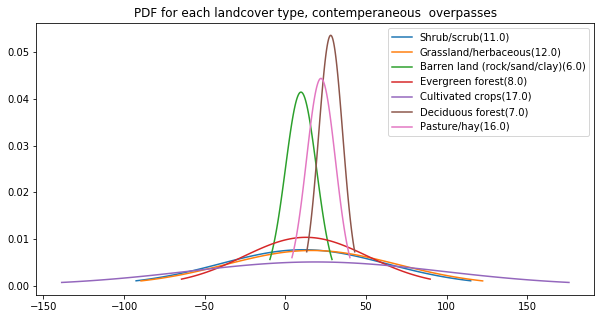

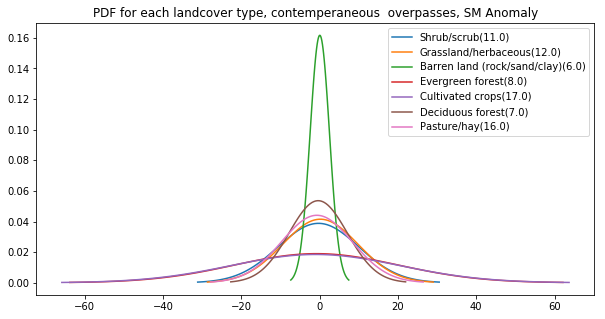

In [39]:
plt.figure(figsize =(10,5))

for i in analysis_df.lc_type.unique():
    lcdf = analysis_df[analysis_df.lc_type==i]
    lctype = lcdf.lc_type.unique()[0]
    mu = np.mean(lcdf.wa.values)
    sigma = np.var(lcdf.wa.values)
    x = np.linspace(mu - 2*sigma, mu + 2*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), label = nlcd[lctype]+ "({})".format(lctype) )

plt.title("PDF for each landcover type, contemperaneous  overpasses")
plt.legend()
plt.show()

plt.figure(figsize =(10,5))

for i in analysis_df.lc_type.unique():
    lcdf = analysis_df[analysis_df.lc_type==i]
    lctype = lcdf.lc_type.unique()[0]
    mu = np.mean(lcdf.wa_anom.values)
    sigma = np.var(lcdf.wa_anom.values)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), label = nlcd[lctype]+ "({})".format(lctype) )

plt.title("PDF for each landcover type, contemperaneous  overpasses, SM Anomaly")
plt.legend()
plt.show()

In [40]:
# Print the variances per lc type for weighted avg
print("Weighted Average variance: \n")

for i in analysis_df.lc_type.unique():
    lcdf = analysis_df[analysis_df.lc_type==i]
    lctype = lcdf.lc_type.unique()[0]
    sigma = np.var(lcdf.wa.values)
    mu = np.mean(lcdf.wa.values)
    print(lctype, nlcd[lctype], "variance = ", round(sigma,2), "mean = ", round(mu,2))

Weighted Average variance: 

11.0 Shrub/scrub variance =  51.88 mean =  11.22
12.0 Grassland/herbaceous variance =  52.97 mean =  16.45
6.0 Barren land (rock/sand/clay) variance =  9.63 mean =  9.71
8.0 Evergreen forest variance =  38.56 mean =  12.74
17.0 Cultivated crops variance =  78.66 mean =  18.61
7.0 Deciduous forest variance =  7.44 mean =  28.15
16.0 Pasture/hay variance =  8.99 mean =  22.09


In [41]:

# Print the variances per lc type for weighted avg anomaly
print("Weighted Average Anomaly variance: \n")

for i in analysis_df.lc_type.unique():
    lcdf = analysis_df[analysis_df.lc_type==i]
    lctype = lcdf.lc_type.unique()[0]
    sigma = np.var(lcdf.wa_anom.values)
    mu = np.mean(lcdf.wa_anom.values)
    print(lctype, nlcd[lctype], "variance = ", round(sigma,2), "mean = ", round(mu,2))

Weighted Average Anomaly variance: 

11.0 Shrub/scrub variance =  10.28 mean =  -0.32
12.0 Grassland/herbaceous variance =  9.61 mean =  0.17
6.0 Barren land (rock/sand/clay) variance =  2.47 mean =  0.03
8.0 Evergreen forest variance =  21.0 mean =  -0.84
17.0 Cultivated crops variance =  21.6 mean =  -1.08
7.0 Deciduous forest variance =  7.44 mean =  -0.39
16.0 Pasture/hay variance =  9.05 mean =  -0.73


In [42]:
# N samples per landcover type 
analysis_df.lc_type.value_counts()

11.0    1393
17.0    1123
12.0     464
8.0      217
6.0      147
16.0     144
7.0       30
Name: lc_type, dtype: int64

# All times 

In [115]:
lcs={}
lcs_anom = {}
for k,v in lcstats.items():
    vdfs = []
    for i in v:
        vdfs.append(i[0])
    print("{} {} n sites = {} n measurements = {} ".format(k, nlcd[k], len(v), len(pd.concat(vdfs))))
    mean_sm = np.mean(pd.concat(vdfs).wa)
    var_sm = np.var(pd.concat(vdfs).wa)
    lcs[k] = [pd.concat(vdfs).wa.values]
    lcs_anom[k] = [pd.concat(vdfs).wa_anom.values]
    
    print("mean = {} variance = {}".format(round(mean_sm,2), round(var_sm,2)))

12 Grassland/herbaceous n sites = 9 n measurements = 246089 
mean = 15.5 variance = 62.5
11 Shrub/scrub n sites = 32 n measurements = 919297 
mean = 11.71 variance = 60.79
17 Cultivated crops n sites = 20 n measurements = 631832 
mean = 19.81 variance = 89.31
7 Deciduous forest n sites = 1 n measurements = 25762 
mean = 28.54 variance = 10.14
16 Pasture/hay n sites = 3 n measurements = 105333 
mean = 22.85 variance = 9.15
8 Evergreen forest n sites = 4 n measurements = 128013 
mean = 14.22 variance = 54.05
6 Barren land (rock/sand/clay) n sites = 2 n measurements = 46831 
mean = 9.86 variance = 8.45


In [ ]:
# Plot the means / variances for all data at all times

In [127]:
lckeys = [k for k,v in lcstats.items()]
lclabels = [nlcd[k] for k,v in lcstats.items()]

In [128]:
dwa = dict(zip(lckeys, [v[0] for k,v in lcs.items()]))
wadf = pd.DataFrame(dict([(nlcd[k],pd.Series(v)) for k,v in dwa.items()]))

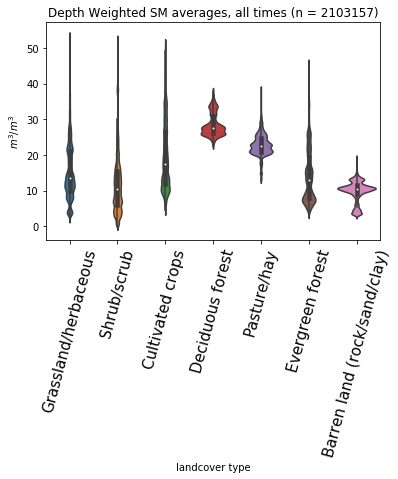

In [129]:
sns.violinplot(data=wadf)
plt.title("Depth Weighted SM averages, all times (n = {})".format(str(wadf.count().sum())))
plt.xlabel("landcover type")
plt.ylabel("$m^3/ m^3$")
plt.xticks(rotation=75, size = 15)
plt.show()

In [130]:
dwa_anom = dict(zip(lckeys, [v[0] for k,v in lcs_anom.items()]))
wadf_anom = pd.DataFrame(dict([(nlcd[k],pd.Series(v)) for k,v in dwa_anom.items()]))

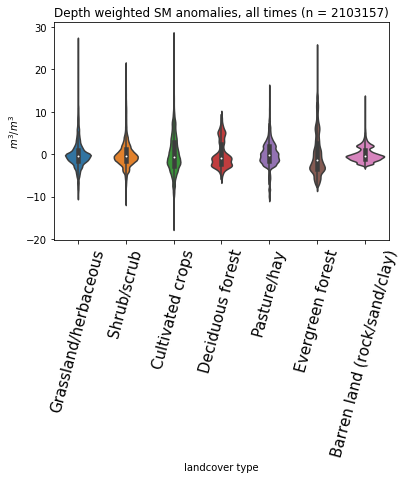

In [131]:
sns.violinplot(data=wadf_anom)
plt.title("Depth weighted SM anomalies, all times (n = {})".format(str(wadf_anom.count().sum())))
plt.xlabel("landcover type")
plt.ylabel("$m^3/ m^3$")
plt.xticks(rotation=75, size = 15)
plt.show()

# 3 am - 7 am on all days

In [122]:

lcs_daily={}
lcs_anom_daily = {}

for k,v in lcstats_daily.items():
    vdfs = []
    for i in v:
        vdfs.append(i[0])
    print("{} {} n sites = {} n measurements = {} ".format(k, nlcd[k], len(v), len(pd.concat(vdfs))))
    mean_sm = np.mean(pd.concat(vdfs).wa)
    var_sm = np.var(pd.concat(vdfs).wa)
    lcs_daily[k] = [pd.concat(vdfs).wa.values]
    lcs_anom_daily[k] = [pd.concat(vdfs).wa_anom.values]
    
    print("mean = {} variance = {}".format(round(mean_sm,2), round(var_sm,2)))

12 Grassland/herbaceous n sites = 9 n measurements = 40792 
mean = 15.49 variance = 62.42
11 Shrub/scrub n sites = 32 n measurements = 153290 
mean = 11.66 variance = 60.42
17 Cultivated crops n sites = 20 n measurements = 104784 
mean = 19.81 variance = 89.51
7 Deciduous forest n sites = 1 n measurements = 4287 
mean = 28.55 variance = 10.07
16 Pasture/hay n sites = 3 n measurements = 17554 
mean = 22.81 variance = 9.1
8 Evergreen forest n sites = 4 n measurements = 21324 
mean = 14.19 variance = 54.27
6 Barren land (rock/sand/clay) n sites = 2 n measurements = 7804 
mean = 9.71 variance = 8.3


In [125]:
dwa_3_7 = dict(zip(lckeys, [v[0] for k,v in lcs_daily.items()]))
wadf_3_7 = pd.DataFrame(dict([(nlcd[k],pd.Series(v)) for k,v in dwa_3_7.items()]))

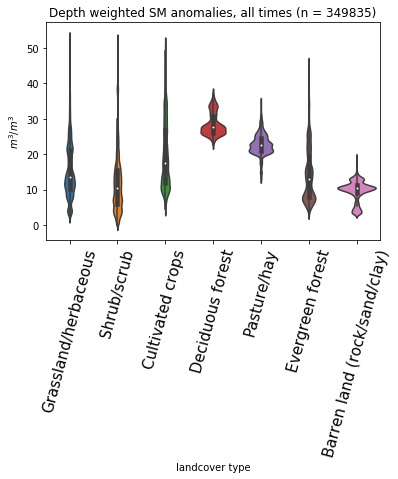

In [133]:
sns.violinplot(data=wadf_3_7)
plt.title("Depth weighted SM anomalies, all times (n = {})".format(str(wadf_3_7.count().sum())))
plt.xlabel("landcover type")
plt.ylabel("$m^3/ m^3$")
plt.xticks(rotation=75, size = 15)
plt.show()

In [134]:
dwa_3_7_anom = dict(zip(lckeys, [v[0] for k,v in lcs_anom_daily.items()]))
wadf_3_7_anom = pd.DataFrame(dict([(nlcd[k],pd.Series(v)) for k,v in dwa_3_7_anom.items()]))

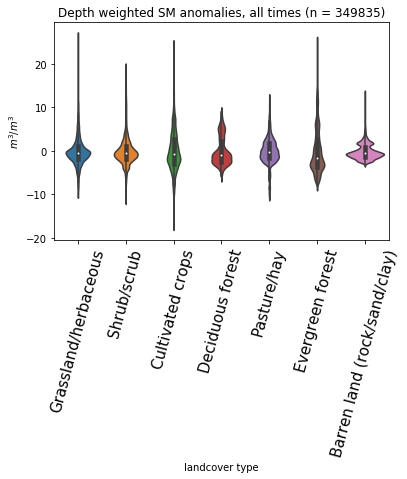

In [135]:
sns.violinplot(data=wadf_3_7_anom)
plt.title("Depth weighted SM anomalies, all times (n = {})".format(str(wadf_3_7_anom.count().sum())))
plt.xlabel("landcover type")
plt.ylabel("$m^3/ m^3$")
plt.xticks(rotation=75, size = 15)
plt.show()

In [136]:
# For each landcover type, look at the mean / variance for each depth (5, 10, 20, 50, 100) and the weighted average

In [143]:
for k,v in lcstats.items():
    vdfs = []
    for i in v:
        vdfs.append(i[0])
    lcdf = pd.concat(vdfs)
    

Index(['d5', 'd10', 'd20', 'd50', 'd100', 'wa', 'wa_anom'], dtype='object')
Index(['d5', 'd10', 'd20', 'd50', 'd100', 'wa', 'wa_anom'], dtype='object')
Index(['d5', 'd10', 'd20', 'd50', 'd100', 'wa', 'wa_anom'], dtype='object')
Index(['d5', 'd10', 'd20', 'd50', 'd100', 'wa', 'wa_anom'], dtype='object')
Index(['d5', 'd10', 'd20', 'd50', 'd100', 'wa', 'wa_anom'], dtype='object')
Index(['d5', 'd10', 'd20', 'd50', 'd100', 'wa', 'wa_anom'], dtype='object')
Index(['d5', 'd10', 'd20', 'd50', 'd100', 'wa', 'wa_anom'], dtype='object')


In [141]:
for k,v in lcstats.items():
    print(k)
    
    vdfs = []
    for i in v:
        vdfs.append(i[0])
    print("{} {} n sites = {} n measurements = {} ".format(k, nlcd[k], len(v), len(pd.concat(vdfs))))
    mean_sm = np.mean(pd.concat(vdfs).wa)
    var_sm = np.var(pd.concat(vdfs).wa)
    
    mu = mean_sm
    variances = var_sm
    depths = ['5cm', '10cm', '20cm', "50cm", "100cm", "weighted avg"]
    
    for idx,i in enumerate(zip(mus,variances)):
        sigma = math.sqrt(i[1])
        x = np.linspace(i[0] - 3*sigma, i[0] + 3*sigma, 100)
        line = plt.plot(x, stats.norm.pdf(x, i[0], sigma), label = depths[idx])

    plt.title("{} {} Depth PDFs ".format(k,nlcd[k]))
    plt.legend()
    plt.show()
    

12
12 Grassland/herbaceous n sites = 9 n measurements = 246089 


TypeError: zip argument #1 must support iteration

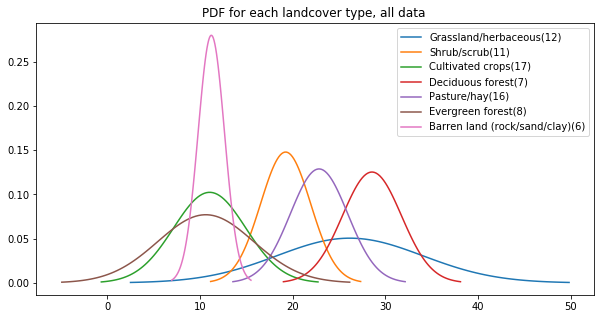

In [225]:
# Plot the PDF for each landcover type (all times)

plt.figure(figsize = (10,5))

for k,v in lcstats.items():
    mu = np.mean(v[-2])
    var = np.var(v[-2])
    sigma = math.sqrt(var)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), label = nlcd[k]+ "({})".format(k) )

plt.title("PDF for each landcover type, all data ")
plt.legend()
plt.show()

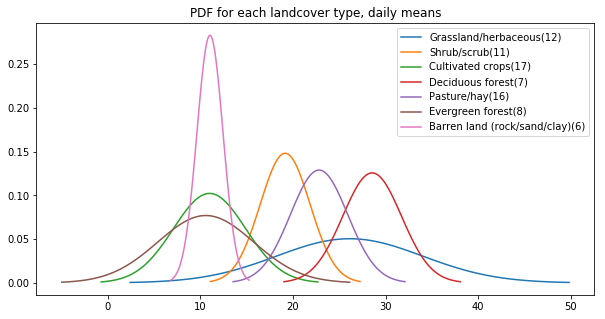

In [226]:
# Plot the PDF for each landcover type (daily means)

plt.figure(figsize = (10,5))

for k,v in lcstats_daily.items():
    mu = np.mean(v[-2])
    var = np.var(v[-2])
    sigma = math.sqrt(var)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), label = nlcd[k]+ "({})".format(k) )

plt.title("PDF for each landcover type, daily means")
plt.legend()
plt.show()

# Look at site specific averages

In [281]:
# Compile the spatial and temporal stats 

tempdf = []

for k,v in temporal_stats.items():
    sdf = sites[sites.id == k]
    sdf['sm_mean_t'] = np.mean(v[-1])
    sdf['sm_var_t'] = np.var(v[-1])
    tempdf.append(sdf)

spatialdf = []

for k,v in spatial_stats.items():
    sdf = sites[sites.id == k]
    sdf['sm_mean_t'] = np.mean(v[-1])
    sdf['sm_var_t'] = np.var(v[-1])
    spatialdf.append(sdf)

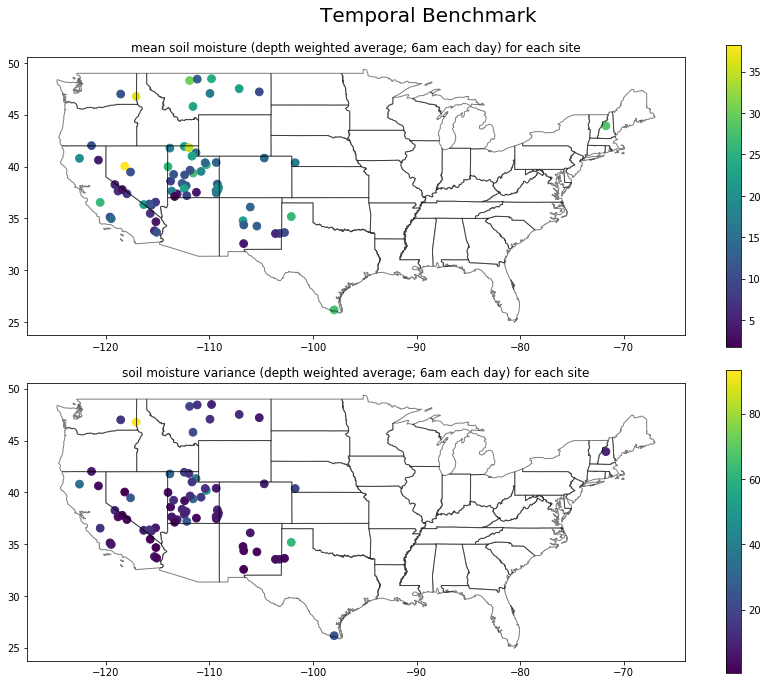

In [282]:
fig, ax = plt.subplots(nrows = 2,figsize = (12,10))

fig.suptitle("Temporal Benchmark", size = 20)

ax[0].set_title("mean soil moisture (depth weighted average; all times) for each site")
pd.concat(tempdf).plot(ax = ax[0], column = "sm_mean_t",markersize = 60, legend = True)
states.plot(ax = ax[0], color = "none", edgecolor = "black", alpha = 0.5,  linewidth = 1)

ax[1].set_title("soil moisture variance (depth weighted average; all times) for each site")
pd.concat(tempdf).plot(ax = ax[1], column = "sm_var_t",markersize = 60, legend = True)
states.plot(ax = ax[1], color = "none", edgecolor = "black", alpha = 0.5,  linewidth = 1)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [227]:
# Compile the spatial and temporal stats 

tempdf = []

for k,v in temporal_stats.items():
    sdf = sites[sites.id == k]
    sdf['sm_mean_t'] = v[0]
    sdf['sm_var_t'] = v[1]
    tempdf.append(sdf)

spatialdf = []

for k,v in spatial_stats.items():
    sdf = sites[sites.id == k]
    sdf['sm_mean_s'] = v[0]
    sdf['sm_var_s'] = v[1]
    spatialdf.append(sdf)

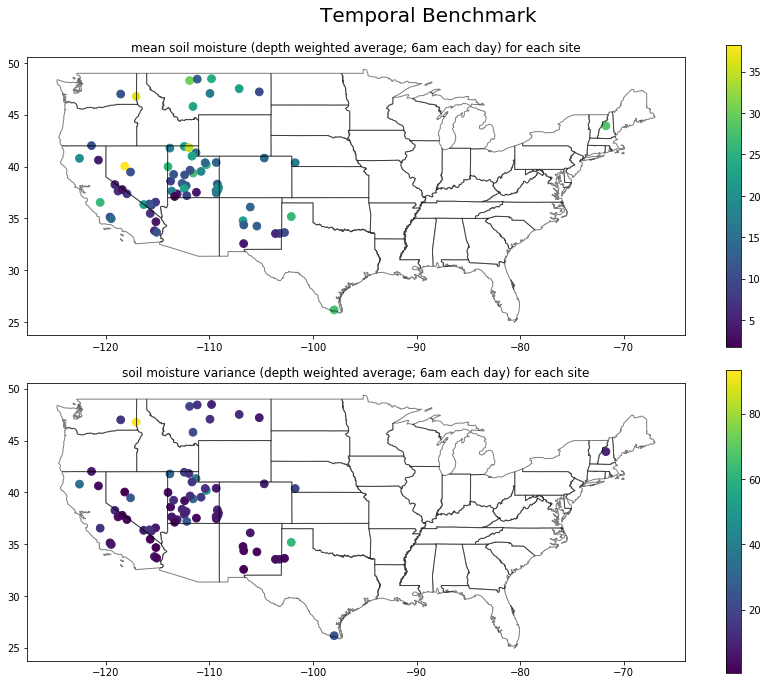

In [228]:
fig, ax = plt.subplots(nrows = 2,figsize = (12,10))

fig.suptitle("Temporal Benchmark", size = 20)

ax[0].set_title("mean soil moisture (depth weighted average; 6am each day) for each site")
pd.concat(tempdf).plot(ax = ax[0], column = "sm_mean_t",markersize = 60, legend = True)
states.plot(ax = ax[0], color = "none", edgecolor = "black", alpha = 0.5,  linewidth = 1)

ax[1].set_title("soil moisture variance (depth weighted average; 6am each day) for each site")
pd.concat(tempdf).plot(ax = ax[1], column = "sm_var_t",markersize = 60, legend = True)
states.plot(ax = ax[1], color = "none", edgecolor = "black", alpha = 0.5,  linewidth = 1)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

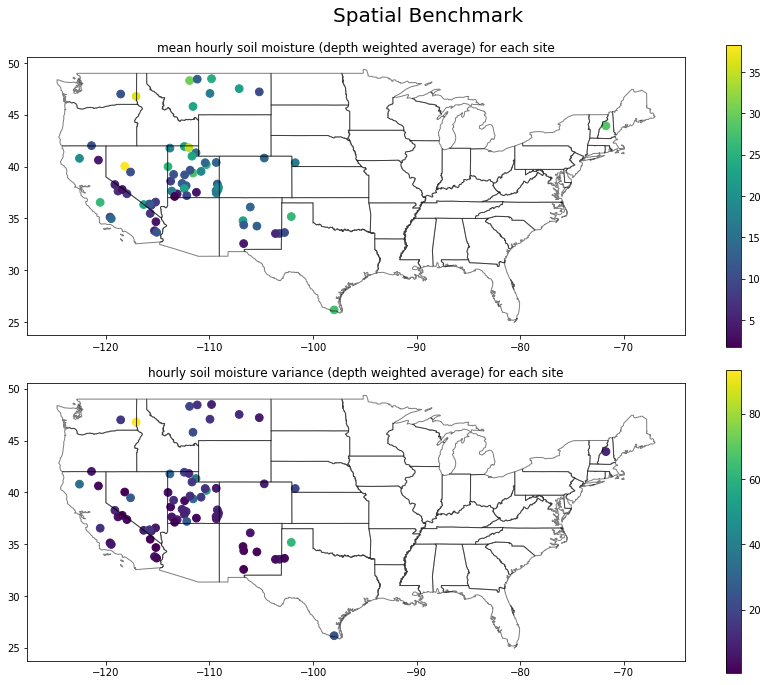

In [229]:
fig, ax = plt.subplots(nrows = 2,figsize = (12,10))

fig.suptitle("Spatial Benchmark", size = 20)

ax[0].set_title("mean hourly soil moisture (depth weighted average) for each site")
pd.concat(spatialdf).plot(ax = ax[0], column = "sm_mean_s",markersize = 60, legend = True)
states.plot(ax = ax[0], color = "none", edgecolor = "black", alpha = 0.5,  linewidth = 1)

ax[1].set_title("hourly soil moisture variance (depth weighted average) for each site")
pd.concat(spatialdf).plot(ax = ax[1], column = "sm_var_s",markersize = 60, legend = True)
states.plot(ax = ax[1], color = "none", edgecolor = "black", alpha = 0.5,  linewidth = 1)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

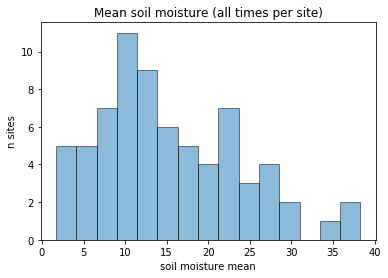

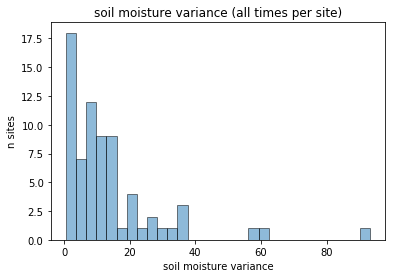

In [230]:
plt.hist(pd.concat(tempdf).sm_mean_t.values, bins = 15, alpha = 0.5, edgecolor='black',)
plt.title("Mean soil moisture (all times per site)")
plt.xlabel("soil moisture mean")
plt.ylabel("n sites")
plt.show()
plt.hist(pd.concat(tempdf).sm_var_t.values, bins = 30, alpha = 0.5, edgecolor='black',)
plt.title("soil moisture variance (all times per site)")
plt.xlabel("soil moisture variance")
plt.ylabel("n sites")
plt.show()

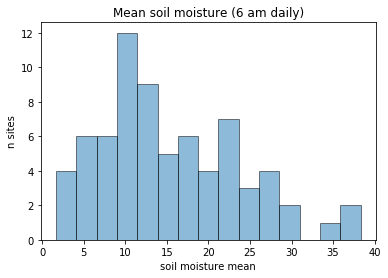

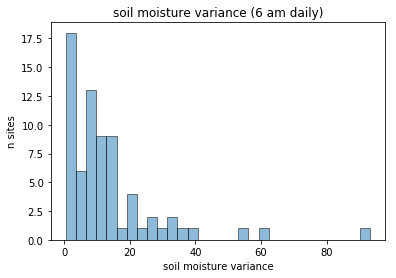

In [231]:
plt.hist(pd.concat(spatialdf).sm_mean_s.values, bins = 15, alpha = 0.5, edgecolor='black',)
plt.title("Mean soil moisture (6 am daily)")
plt.xlabel("soil moisture mean")
plt.ylabel("n sites")
plt.show()
plt.hist(pd.concat(spatialdf).sm_var_s.values, bins = 30, alpha = 0.5, edgecolor='black',)
plt.title("soil moisture variance (6 am daily)")
plt.xlabel("soil moisture variance")
plt.ylabel("n sites")
plt.show()

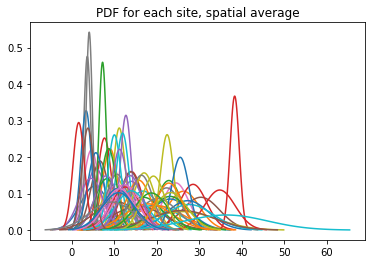

Text(0.5, 1.0, 'PDF for each site, temporal average')

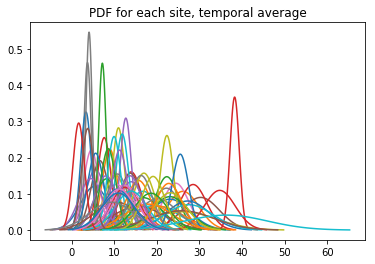

In [232]:
for k,v in spatial_stats.items():
#     mu = v[0]
#     var = v[1]
    mu = np.mean(v[-1])
    var = np.var(v[-1])
    sigma = math.sqrt(var)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma))

plt.title("PDF for each site, all times mean")
plt.show()

for k,v in temporal_stats.items():
    mu = np.mean(v[-1])
    var = np.var(v[-1])
    sigma = math.sqrt(var)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma))

plt.title("PDF for each site, 3am - 7am")

# Make baseline predictions: 

Use the spatial and temporal mean at each site to calculate a baseline RMSE, bias, R^2:

$$R^2 =  1 - \frac {\sum_{i=1}^{n} (x_i - \hat{x})^2}{\sum_{i=1}^{n} (x_i - \bar{x})^2 }$$

$$RMSE =  \sqrt{{ \frac{{\sum_{i=1}^{n} (x_i - \bar{x})^2}} {n} }}$$

$$bias =  \frac {1}{n} {\sum_{i=1}^{n} (x_i - \bar{x})^2 }$$


In [269]:
len(pd.concat(spatialdf))

71

# Baseline 1: Site means at overpass times

In [233]:
# Take the site specific average and calc R^2 and RMSE 

In [234]:
site_means = pd.concat(spatialdf)
site_means.id = site_means.id.astype(np.float64)

keepcols = [x for x in  site_means.columns if x not in analysis_df.columns]

In [235]:
site_means.id.astype(int)
analysis_df.id.astype(int)
adf = analysis_df.merge(site_means, on='id')

In [236]:
# Calc R^2
A = np.vstack([adf.sm_mean_s, np.ones(len(adf.sm_mean_s))]).T
solution = np.linalg.lstsq(A, adf.wa)
m, c = solution[0]
residuals = solution[1]
r2 = 1 - residuals / sum((adf.wa - adf.wa.mean())**2) 

In [237]:
#  RMSE, bias
naive_rmse = ((adf.wa - adf.sm_mean_s) ** 2).mean() ** .5
naive_bias = ((adf.wa - adf.sm_mean_s)).mean()

print(naive_rmse)
print(naive_bias)

3.8145467861161637
-0.5331723505227894


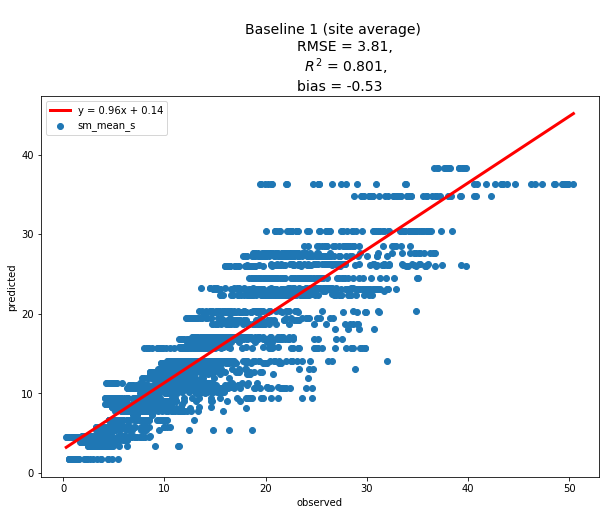

In [238]:
plt.figure(figsize = (10,7))
plt.scatter(adf.wa,adf.sm_mean_s)
plt.plot(np.unique(adf.wa.values), np.poly1d(np.polyfit(adf.wa.values, adf.sm_mean_s.values, 1))(np.unique(adf.wa.values)), 
         c = "red", linewidth = 3,
         label='y = {}x + {}'.format(round(m,2),round(c,2)))
plt.legend()
plt.ylabel("predicted")
plt.xlabel("observed")
plt.title('''
      Baseline 1 (site average)
            RMSE = {}, 
            $R^2$ = {}, 
          bias = {} '''.format(round(naive_rmse,2), round(r2[0],3), round(naive_bias,2)), size = 14 )
plt.show()

In [239]:
# Distribution of Site specific RMSEs, bias, variances
rmses = []
biases = []
variances = []
for i in adf.site.unique():
    sdf = adf[adf.site == i]
    site_rmse = ((sdf.wa - sdf.sm_mean_s) ** 2).mean() ** .5
    site_var = np.var(sdf.wa)
    site_bias = ((sdf.wa - sdf.sm_mean_s)).mean()
    variances.append(site_var)
    rmses.append(site_rmse)
    biases.append(site_bias)

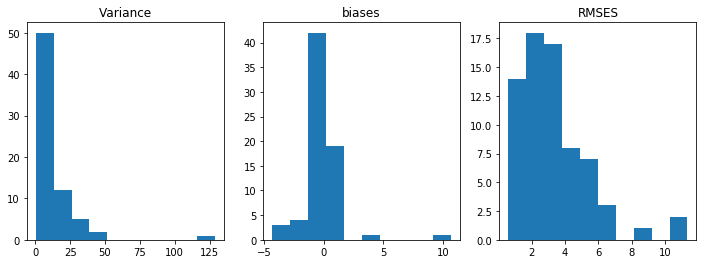

In [240]:
plt.figure(figsize = (12,4))
plt.title("Site specific statistics")

plt.subplot(1,3,1)
plt.hist(np.array(variances))
plt.title("Variance")

plt.subplot(1,3,2)
plt.hist(np.array(biases))
plt.title("biases")

plt.subplot(1,3,3)
plt.hist(np.array(rmses))
plt.title("RMSES")

plt.show()

# Baseline 2: Landcover type means - all times, 3am - 7 am

In [321]:
lcstats[12]

[array([ 48.57650417,  49.1528457 ,  43.69373785, 150.92556021,
         83.88963889,  62.2152656 ,  62.2152656 ]),
 array([1.65229827e+01, 1.91016776e+01, 3.10671154e+01, 2.55623427e+01,
        2.84686126e+01, 2.61516910e+01, 5.61365713e-15]),
 [Date
  2015-01-14 00:00:00     6.5
  2015-01-14 01:00:00     7.9
  2015-01-14 02:00:00     8.0
  2015-01-14 03:00:00     7.3
  2015-01-14 04:00:00     6.5
  2015-01-14 05:00:00     7.9
  2015-01-14 06:00:00     6.4
  2015-01-14 07:00:00     7.7
  2015-01-14 08:00:00     8.3
  2015-01-14 09:00:00     6.6
  2015-01-14 10:00:00     7.4
  2015-01-14 11:00:00     8.1
  2015-01-14 12:00:00     7.1
  2015-01-14 13:00:00     6.8
  2015-01-14 14:00:00     7.4
  2015-01-14 15:00:00     6.5
  2015-01-14 16:00:00     7.2
  2015-01-14 17:00:00     6.7
  2015-01-14 18:00:00     8.1
  2015-01-14 19:00:00     8.0
  2015-01-14 20:00:00     7.9
  2015-01-14 21:00:00     7.9
  2015-01-14 22:00:00     7.3
  2015-01-14 23:00:00     7.1
  2015-01-15 00:00:00     7

In [320]:
lct_mean_all = []
lct_mean_3_7 = []

for i in analysis_df.iterrows():
    lct = i[1]['lc_type']
    
    print(len(lcstats[lct][-2]))
    
    lctm = np.mean(lcstats[lct][-2])
    lct_mean_all.append(lctm)
    
    lctm_3_7 = np.mean(lcstats_daily[lct][2].wa)
    print(len(lcstats_daily[lct][2].wa))
    
    
    print(lctm, lctm_3_7)
    lct_mean_3_7.append(lctm_3_7)


30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.15601904

5881
11.207473004825824 11.03646641093859
35299
5881
11.207473004825824 11.03646641093859
35299
5881
11.207473004825824 11.03646641093859
35299
5881
11.207473004825824 11.03646641093859
35299
5881
11.207473004825824 11.03646641093859
35299
5881
11.207473004825824 11.03646641093859
35299
5881
11.207473004825824 11.03646641093859
35299
5881
11.207473004825824 11.03646641093859
35299
5881
11.207473004825824 11.03646641093859
35299
5881
11.207473004825824 11.03646641093859
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.15601904729213

5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.15601904729213

5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.9902024100306

5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.9902024100306

5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.9902024100306

5880
10.60790402643921 10.581005325078566
35291
5880
10.60790402643921 10.581005325078566
35291
5880
10.60790402643921 10.581005325078566
35291
5880
10.60790402643921 10.581005325078566
35291
5880
10.60790402643921 10.581005325078566
35291
5880
10.60790402643921 10.581005325078566
35291
5880
10.60790402643921 10.581005325078566
35291
5880
10.60790402643921 10.581005325078566
35291
5880
10.60790402643921 10.581005325078566
35291
5880
10.60790402643921 10.581005325078566
35291
5880
10.60790402643921 10.581005325078566
35291
5880
10.60790402643921 10.581005325078566
35291
5880
10.60790402643921 10.581005325078566
35291
5880
10.60790402643921 10.581005325078566
35291
5880
10.60790402643921 10.581005325078566
35291
5880
10.60790402643921 10.581005325078566
35291
5880
10.60790402643921 10.581005325078566
35291
5880
10.60790402643921 10.581005325078566
35291
5880
10.60790402643921 10.581005325078566
35291
5880
10.60790402643921 10.581005325078566
35291
5880
10.60790402643921 10.58100532507856

5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.9902024100306

5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.9902024100306

5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.15601904729213

5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
30601
5099
19.22748005315519 19.156019047292137
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.9902024100306

5883
22.832081476477654 22.816434208277766
35296
5883
22.832081476477654 22.816434208277766
35296
5883
22.832081476477654 22.816434208277766
35296
5883
22.832081476477654 22.816434208277766
35296
5883
22.832081476477654 22.816434208277766
35296
5883
22.832081476477654 22.816434208277766
35296
5883
22.832081476477654 22.816434208277766
35296
5883
22.832081476477654 22.816434208277766
35296
5883
22.832081476477654 22.816434208277766
35296
5883
22.832081476477654 22.816434208277766
35296
5883
22.832081476477654 22.816434208277766
35296
5883
22.832081476477654 22.816434208277766
35296
5883
22.832081476477654 22.816434208277766
35296
5883
22.832081476477654 22.816434208277766
35296
5883
22.832081476477654 22.816434208277766
35296
5883
22.832081476477654 22.816434208277766
35296
5883
22.832081476477654 22.816434208277766
35296
5883
22.832081476477654 22.816434208277766
35296
5883
22.832081476477654 22.816434208277766
35296
5883
22.832081476477654 22.816434208277766
35296
5883
22.832081476477

5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.9902024100306

5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.99020241003062
34499
5749
11.029411546423878 10.9902024100306

In [312]:
analysis_df['lct_mean_all'] = lct_mean_all
analysis_df['lct_mean_3_7'] = lct_mean_3_7

In [313]:
# Calc R^2
A = np.vstack([analysis_df.lct_mean_all, np.ones(len(analysis_df.lct_mean_all))]).T
solution = np.linalg.lstsq(A, analysis_df.wa)
m, c = solution[0]
residuals = solution[1]
r2 = 1 - residuals / sum((analysis_df.wa - analysis_df.wa.mean())**2) 

In [314]:
#  RMSE, bias
naive_rmse = ((analysis_df.wa - analysis_df.lct_mean_all) ** 2).mean() ** .5
naive_bias = ((analysis_df.wa - analysis_df.lct_mean_all)).mean()

print(naive_rmse)
print(naive_bias)

10.602419795950828
-1.994682347943932


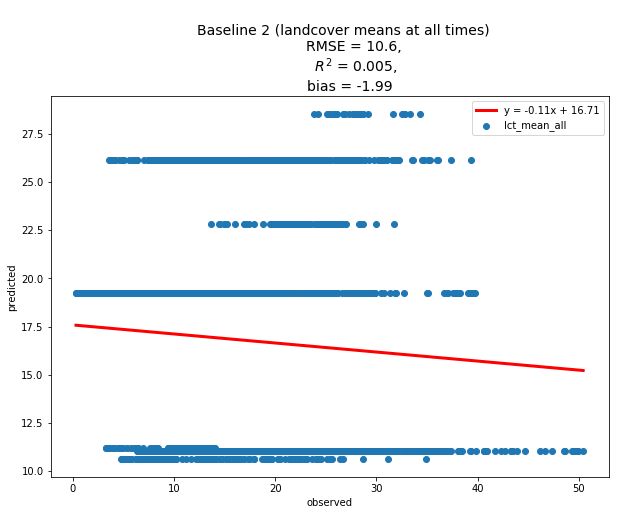

In [315]:
plt.figure(figsize = (10,7))
plt.scatter(analysis_df.wa,analysis_df.lct_mean_all)
plt.plot(np.unique(analysis_df.wa.values), np.poly1d(np.polyfit(analysis_df.wa.values, analysis_df.lct_mean_all.values, 1))(np.unique(analysis_df.wa.values)), 
         c = "red", linewidth = 3,
         label='y = {}x + {}'.format(round(m,2),round(c,2)))
plt.legend()
plt.ylabel("predicted")
plt.xlabel("observed")
plt.title('''
      Baseline 2 (landcover means at all times)
            RMSE = {}, 
            $R^2$ = {}, 
          bias = {} '''.format(round(naive_rmse,2), round(r2[0],3), round(naive_bias,2)), size = 14 )
plt.show()

In [316]:
# # Calc R^2
A = np.vstack([analysis_df.lct_mean_3_7, np.ones(len(analysis_df.lct_mean_3_7))]).T
solution = np.linalg.lstsq(A, analysis_df.wa)
m, c = solution[0]
residuals = solution[1]
r2 = 1 - residuals / sum((analysis_df.wa - analysis_df.wa.mean())**2) 

In [317]:
#  RMSE, bias
naive_rmse = ((analysis_df.wa - analysis_df.lct_mean_3_7) ** 2).mean() ** .5
naive_bias = ((analysis_df.wa - analysis_df.lct_mean_3_7)).mean()

print(naive_rmse)
print(naive_bias)

10.584993082872458
-1.939594064276006


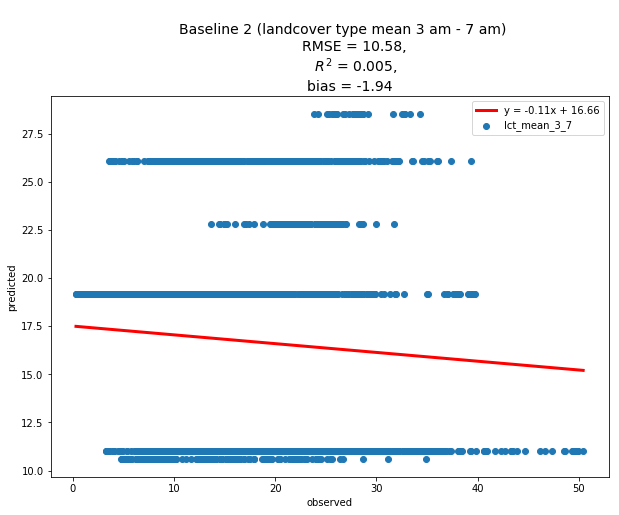

In [318]:
plt.figure(figsize = (10,7))
plt.scatter(analysis_df.wa,analysis_df.lct_mean_3_7)
plt.plot(np.unique(analysis_df.wa.values), np.poly1d(np.polyfit(analysis_df.wa.values, analysis_df.lct_mean_3_7.values, 1))(np.unique(analysis_df.wa.values)), 
         c = "red", linewidth = 3,
         label='y = {}x + {}'.format(round(m,2),round(c,2)))
plt.legend()
plt.ylabel("predicted")
plt.xlabel("observed")
plt.title('''
      Baseline 2 (landcover type mean 3 am - 7 am)
            RMSE = {}, 
            $R^2$ = {}, 
          bias = {} '''.format(round(naive_rmse,2), round(r2[0],3), round(naive_bias,2)), size = 14 )
plt.show()

# EDA takeaways
The landcover type tells you close to nothing about soil moisture <br>
Site specific soil moisture is a

In [ ]:
# Setup for the LSTM 

In [ ]:
analysis_df.drop(["id"], axis = 1, inplace = True)
df = analysis_df.copy()

In [ ]:
# Drop nonconsecutive rows 

t = df.copy()

filtered = []

for i in t.site.unique():
    sdf = t[t.site==i]
    
    for i in sdf.index:
        begin = i
        end = begin + pd.Timedelta(days=12)
        temp = sdf[begin:end]
        num_points = len(temp)
        if num_points<1:
            print(t)
        else:
            filtered.append(temp)

filt = pd.concat(filtered).dropna()

df = filt.copy()

In [ ]:
# Calc 12 day means 
df = df.groupby(['site']).resample('12D').mean().fillna(np.nan).dropna()

In [ ]:
# Drop the non interpolated landsat bands
df.drop(["B1", "B2", "B3", "B4", "B5", "B6", "B7"], axis = 1,inplace = True)
df.rename(columns={'B1_filt': 'B1', 'B2_filt': 'B2','B3_filt': 'B3','B4_filt': 'B4','B5_filt': 'B5','B6_filt': 'B6','B7_filt': 'B7'}, inplace=True)

In [ ]:
# One hot encode the landcover types 
one_hot = pd.get_dummies(df.lc_type, drop_first=True )
rdf = pd.concat([df, one_hot], axis = 1)
rdf = rdf.drop(["lc_type"], axis = 1)
df = rdf.dropna()

# Convert hte col names to strings 
df.columns = df.columns.map(str)

In [ ]:
# Add the time lagged predictors 
s1 = df.groupby(level="site").shift(1)
# s1 = df.groupby("site").shift(1)
df1 = df.join(s1.rename(columns=lambda x: x+"_t1"))

s2 = df.groupby(level="site").shift(2)
# s2 = df.groupby("site").shift(2)
df2 = df1.join(s2.rename(columns=lambda x: x+"_t2"))

df3 = df2.copy()

In [ ]:
# Drop irrelevant columns 

dropstrs = ['site','precip', 'rzsm', 'ssm', 'psi_rz', "psi_s", "ws_"]
dropcols = []

for i in df3.columns:
    for x in dropstrs:
        if x in i:
            dropcols.append(i)
            
df3 = df3.drop(dropcols, axis = 1)
# df = df3.dropna()

In [ ]:
# Reset the index and drop nans 
df = df3.reset_index(level='site')
df = df.dropna()

In [ ]:
# Modeling options

EPOCHS = 100
BATCHSIZE = 50
DROPOUT = 0.25
LOSS = 'mse'

Areg = regularizers.l1(0.00005)
Breg = regularizers.l2(0.0001)
Kreg = regularizers.l2(1e-15)
Rreg = regularizers.l2(1e-15)

def build_model(input_shape):
    # make the model 
    model = Sequential()
    
    model.add(LSTM(100, input_shape=input_shape, dropout = 0.15,recurrent_dropout=0.15,return_sequences=True,bias_regularizer= Breg))
#     model.add(LSTM(50, input_shape=input_shape, dropout = 0.15,recurrent_dropout=0.15,return_sequences=True,bias_regularizer= Breg))
    model.add(Dropout(0.2))
    model.add(LSTM(10, input_shape=input_shape, dropout = 0.05,recurrent_dropout=0.20,bias_regularizer= Breg))

    model.add(Dense(1))
    model.compile(loss=LOSS, optimizer= optimizers.Nadam(lr=0.01),
                  metrics=['mse'])
    
    return model

# Leave one site out CV

In [ ]:
out = {"train_preds":[],
       "test_preds":[],
       "train_act":[],
       "test_act":[]  
        }

In [ ]:
# Randomly loop through the sites 
for i in random.sample(set(df.site.unique()), len(df.site.unique())):

    print("Processing {}".format(i))
    
    # Select the random site as test, all other sites as train 
    sdf = df[df.site == i]
    y_test = sdf.ws
    X_test = sdf.drop(["site","ws"], axis=1)

    nsdf = df[df.site != i]
    y_train = nsdf.ws 
    X_train = nsdf.drop(["site","ws"], axis=1)
        
    # Scale data
    transformer_x = StandardScaler().fit(X_train)
    transformer_y = StandardScaler().fit(np.array(y_train).reshape(-1, 1)) 
    
#     transformer_x = MinMaxScaler(feature_range=(0,1)).fit(X_train)
#     transformer_y = MinMaxScaler(feature_range=(0,1)).fit(np.array(y_train).reshape(-1, 1)) 
    
    X_train = transformer_x.transform(X_train)
    y_train = transformer_y.transform(np.array(y_train).reshape(-1, 1))
    X_test = transformer_x.transform(X_test)
    y_test = transformer_y.transform(np.array(y_test).reshape(-1, 1))
    
    # LSTM params
    n_lags = 3
    n_features = 19

    X_train = X_train.reshape((X_train.shape[0], n_lags, 24))
    X_test = X_test.reshape((X_test.shape[0], n_lags, 24))

    input_shape=(X_train.shape[1], X_train.shape[2])
    
    model = build_model(input_shape=input_shape)
    
    # Fit
#     model.fit(X_train, y_train, epochs=1000, batch_size=1000, verbose=1)
    
    train_history = model.fit(X_train, y_train,epochs = 500,
                    batch_size=500,
                    verbose=0, validation_data=(X_test, y_test))
    loss = train_history.history['loss']
    val_loss = train_history.history['val_loss']
    val_acc = train_history.history['val_mean_squared_error']

    # Get the predictions
    yhat_train = model.predict(X_train)
    
    trainPredict = transformer_y.inverse_transform(yhat_train.reshape(-1,1))
    trainY = transformer_y.inverse_transform(y_train)
    
    yhat = model.predict(X_test)
    testPredict = transformer_y.inverse_transform(yhat.reshape(-1,1))
    testY = transformer_y.inverse_transform(y_test)

    trainScore = math.sqrt(mean_squared_error(y_train, trainPredict))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(y_test, testPredict))
    print('Test Score: %.2f RMSE' % (testScore))
    
    out["test_preds"] = testPredict
    out["train_preds"] = trainPredict
    
    out["test_act"] = testY
    out["train_act"] = trainY
    
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['loss', 'val_loss'])
    plt.show()

    plt.scatter(trainPredict, trainY)
    plt.scatter(testPredict, testY)
    plt.plot([0, 100], [0, 100], 'k-')
    plt.title('''
                train set RMSE = {}
                test set RMSE = {}
                '''.format(round(trainScore,2),round(testScore,2)))

    plt.xlabel("predicted")
    plt.ylabel("actual")
    plt.show()

# K fold CV

In [ ]:
out = {"train_preds":[[]],
       "test_preds":[[]],
       "train_act":[[]],
       "test_act":[[]]  
        }

In [ ]:
kf = KFold(n_splits=3, shuffle=True, random_state=10)
Y = df.ws.values
X = df.loc[:, df.columns != 'ws'].drop("site", axis = 1).values

In [ ]:
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    # Scale data
#     transformer_x = StandardScaler().fit(X_train)
#     transformer_y = StandardScaler().fit(np.array(y_train).reshape(-1, 1)) 
    
    transformer_x = MinMaxScaler(feature_range=(0,1)).fit(X_train)
    transformer_y = MinMaxScaler(feature_range=(0,1)).fit(np.array(y_train).reshape(-1, 1)) 
    
    X_train = transformer_x.transform(X_train)
    y_train = transformer_y.transform(np.array(y_train).reshape(-1, 1))
    X_test = transformer_x.transform(X_test)
    y_test = transformer_y.transform(np.array(y_test).reshape(-1, 1))
    
    # LSTM params
    n_lags = 3
    n_features = 24

    # Reshape inputs
    X_train = X_train.reshape((X_train.shape[0], n_lags, n_features))
    X_test = X_test.reshape((X_test.shape[0], n_lags, n_features))

    input_shape=(X_train.shape[1], X_train.shape[2])
    
    # Build model
    model = build_model(input_shape=input_shape)

    # Fit model
    train_history = model.fit(X_train, y_train, epochs=1000, batch_size=250, verbose=1,validation_data=(X_test, y_test))
    loss = train_history.history['loss']
    val_loss = train_history.history['val_loss']
    val_acc = train_history.history['val_mean_squared_error']
    
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    
    # evaluate the model
    scores = model.evaluate(X_test, y_test, verbose=1)
    print("%s: %.2f%% (+/- %.2f%%)" % (model.metrics_names[1],np.std(scores[1]*100), scores[1]*100))

    # Get the predictions
    yhat_train = model.predict(X_train)
    trainPredict = transformer_y.inverse_transform(yhat_train.reshape(-1,1))
    trainY = transformer_y.inverse_transform(y_train)
    
    yhat = model.predict(X_test)
    testPredict = transformer_y.inverse_transform(yhat.reshape(-1,1))
    testY = transformer_y.inverse_transform(y_test)

    # Calc RMSE 
    rmse_test = np.sqrt(np.mean((y_test - testPredict)**2))
    
    trainScore = np.sqrt(mean_squared_error(y_train, trainPredict))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = np.sqrt(mean_squared_error(y_test, testPredict))
    print('Test Score: %.2f RMSE' % (testScore))
    print(rmse_test)
    
    # Calc R^2
    A = np.vstack([testPredict.reshape(testPredict.shape[0]), np.ones(len(testPredict.reshape(testPredict.shape[0])))]).T
    solution = np.linalg.lstsq(A, testY)
    m, c = solution[0]
    residuals = solution[1]
    r2 = 1 - residuals / sum((testY - testY.mean())**2) 
    
    # Calc ubRMSE
    ubrmse = np.sqrt(np.mean(((testY - np.mean(testY)) - (testPredict - np.mean(testPredict)))**2))
    
    # Calc Bias 
    bias = np.mean(testY - testPredict)
    
    out["test_preds"].append(testPredict)
    out["train_preds"].append(trainPredict)
    
    out["test_act"].append(testY)
    out["train_act"].append(trainY)
    
    # Train / Test loss 
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['loss', 'val_loss'])
    plt.show()

    # Predicted vs actual
    plt.scatter(trainPredict, trainY, alpha = 0.2, label = "train")
    plt.scatter(testPredict, testY, alpha = 0.2, label = "test")
    plt.plot(testY, m*testY + c, 'r', label='y = {}x + {}'.format(str(round(m[0],2)), str(round(c[0],2))))
    plt.plot([0, 100], [0, 100], "gray", label = "1-1 line")
    plt.title('''
                train set RMSE = {}
                test set RMSE = {}
                test set $R^2$ = {}
                test set ubrmse = {}
                test set bias = {}

                '''.format(round(trainScore,2), round(testScore,2),round(r2[0],4), round(ubrmse,3), round(bias,3)))

    plt.xlabel("predicted")
    plt.ylabel("actual")
    plt.legend()
    plt.show()

In [ ]:
all_preds = np.array([item for sublist in np.array([x for x in out['test_preds'] if len(x) !=0]) for item in sublist])
all_obs = np.array([item for sublist in np.array([x for x in out['test_act'] if len(x) !=0]) for item in sublist])

In [ ]:
preds = all_preds.reshape(all_preds.shape[0])
obs = all_obs.reshape(all_obs.shape[0])

In [ ]:
A = np.vstack([preds, np.ones(len(preds))]).T
solution = np.linalg.lstsq(A, obs)
m, c = solution[0]
residuals = solution[1]
r2 = 1 - residuals / sum((obs - obs.mean())**2) 

In [ ]:
# KDE for predictions 

xy = np.vstack([obs,preds])
z = gaussian_kde(xy)(xy)

plt.figure(figsize = (7,7))
plt.scatter(all_obs.reshape(all_obs.shape[0]), all_preds.reshape(all_preds.shape[0]), c=z, s=10, cmap = "hot")
plt.plot(obs, m*obs + c, 'b',linewidth=4, label='y = {}x + {}'.format(str(round(m,2)), str(round(c,2))))
plt.plot([0, 100], [0, 100], "gray", label = "1-1 line")
plt.xlim(0, 60)
plt.ylim(0, 60)

plt.xlabel("predicted")
plt.ylabel("actual")
plt.legend()
plt.show()

In [ ]:
# Gaussian process regression

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

rbf = ConstantKernel(1.0) * RBF(length_scale=1.0)
gpr = GaussianProcessRegressor(kernel=rbf, alpha=noise**2)

# Reuse training data from previous 1D example
gpr.fit(X_train, Y_train)

# Compute posterior predictive mean and covariance
mu_s, cov_s = gpr.predict(X, return_cov=True)

# Obtain optimized kernel parameters
l = gpr.kernel_.k2.get_params()['length_scale']
sigma_f = np.sqrt(gpr.kernel_.k1.get_params()['constant_value'])


# Plot the results
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)

In [ ]:
# Random Forest 

regressor = RandomForestRegressor(n_estimators=5000, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [ ]:
# Make predictions on test data using the model trained on original data
predictions = regressor.predict(X_test)
# Performance metrics
errors = abs(predictions - y_test)
print('Metrics for Random Forest Trained on Original Data')
print('Average absolute error:', round(np.mean(errors), 2), 'degrees.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')